In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, Conv1D, MaxPooling1D, Flatten
from keras.layers import Input, Attention
from sklearn.metrics import mean_squared_error
import tensorflow_probability as tfp
import networkx as nx
from keras.models import Model
import tensorflow as tf

Epoch 1/100
25/25 [==============================] - 7s 66ms/step - loss: 1.8485 - val_loss: 1.8249
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 1.3784 - val_loss: 0.9803
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 0.6142 - val_loss: 0.5848
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3911 - val_loss: 0.4890
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3383 - val_loss: 0.4191
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 0.2991 - val_loss: 0.3741
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2854 - val_loss: 0.3491
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2482 - val_loss: 0.3216
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2367 - val_loss: 0.2946
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2250 - val_loss: 0.2738
Epoch 11

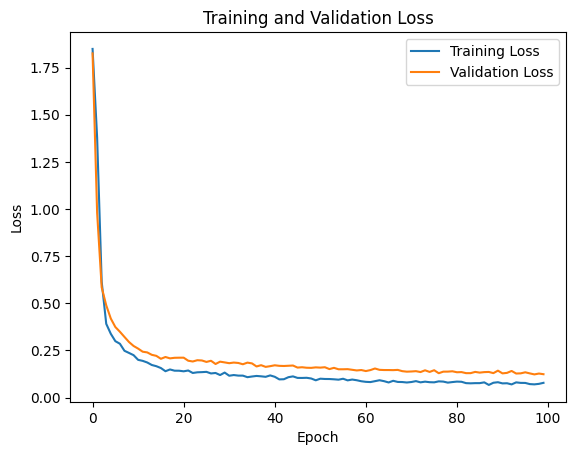

7/7 [==============================] - 0s 3ms/step - loss: 0.1240
Test Loss: 0.12397323548793793
7/7 [==============================] - 1s 3ms/step
Actual vs Predicted Impact:
     Impact  Predicted_Impact
0         0         -0.591395
1         1          1.347256
2         1          0.889158
3         2          1.781840
4        -1         -1.216825
..      ...               ...
195      -1         -0.910000
196       0          0.022339
197       1          0.791042
198      -2         -1.620710
199       2          1.796133

[200 rows x 2 columns]


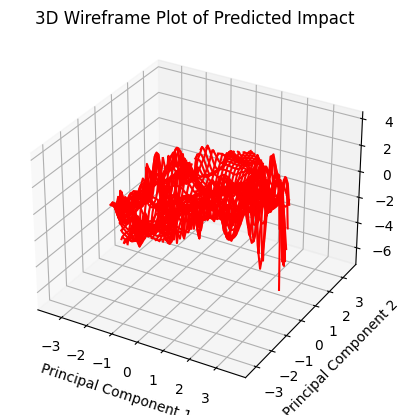

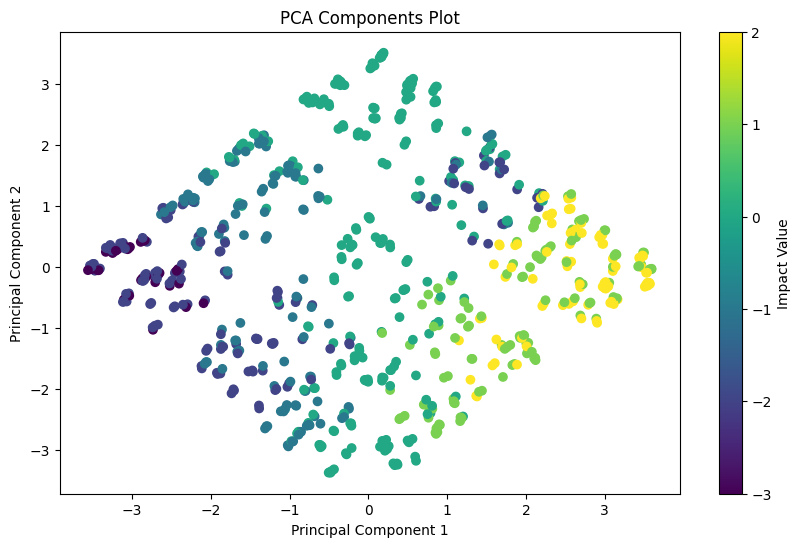

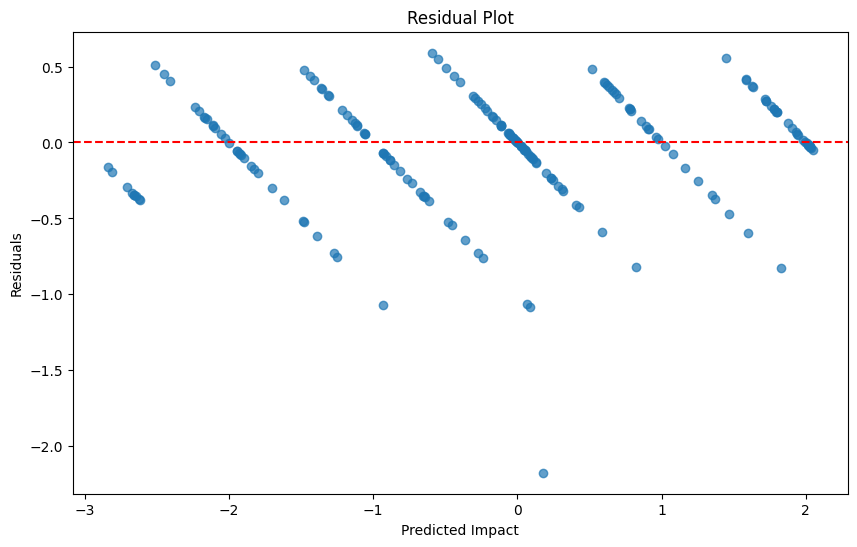

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import griddata

# Load the dataset
data = pd.read_csv("/content/sample_data/output.csv")

# Preprocess the dataset
# Drop unnecessary columns like Name
data = data.drop(columns=["Name"])

# Convert categorical variables to numerical using one-hot encoding
data_encoded = pd.get_dummies(data, columns=["Initial Continent", "Initial Climate", "Final Continent", "Final Climate"])

# Split the dataset into features and target variables
X = data_encoded.drop(columns=["Impact"])
y = data_encoded[["Impact"]]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for LSTM
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer with 1 neuron for Impact

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

# Make predictions
predictions = model.predict(X_test_reshaped)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions, columns=["Predicted_Impact"])

# Reset index for y_test for concatenation
y_test.reset_index(drop=True, inplace=True)

# Concatenate actual and predicted values
results_df = pd.concat([y_test, predictions_df], axis=1)

# Print the results
print("Actual vs Predicted Impact:")
print(results_df)

# Perform PCA on the feature set
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert predictions and actual values to numpy arrays for plotting
predictions_np = predictions.flatten()
y_test_np = y_test.values.flatten()

# Create a DataFrame with PCA components and predictions
pca_df = pd.DataFrame(data=X_test_pca, columns=["PC1", "PC2"])
pca_df["Actual_Impact"] = y_test_np
pca_df["Predicted_Impact"] = predictions_np

# Create a mesh grid for the wireframe plot
grid_x, grid_y = np.meshgrid(
    np.linspace(pca_df["PC1"].min(), pca_df["PC1"].max(), 100),
    np.linspace(pca_df["PC2"].min(), pca_df["PC2"].max(), 100)
)

# Interpolate the predicted impacts for the mesh grid
grid_z = griddata((pca_df["PC1"], pca_df["PC2"]), pca_df["Predicted_Impact"], (grid_x, grid_y), method='cubic')

# Plotting the 3D wireframe plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Wireframe plot for predicted impacts
ax.plot_wireframe(grid_x, grid_y, grid_z, color='r')

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Predicted Impact')
ax.set_title('3D Wireframe Plot of Predicted Impact')

# Show the plot
plt.show()



plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.values.flatten(), cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Components Plot')
plt.colorbar(label='Impact Value')
plt.show()


residuals = y_test_np - predictions_np

plt.figure(figsize=(10, 6))
plt.scatter(predictions_np, residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Impact')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()



Epoch 1/300
25/25 [==============================] - 14s 105ms/step - loss: 1.7083 - val_loss: 1.3715
Epoch 2/300
25/25 [==============================] - 0s 9ms/step - loss: 0.7276 - val_loss: 0.5271
Epoch 3/300
25/25 [==============================] - 0s 11ms/step - loss: 0.3946 - val_loss: 0.4207
Epoch 4/300
25/25 [==============================] - 0s 13ms/step - loss: 0.3117 - val_loss: 0.3706
Epoch 5/300
25/25 [==============================] - 0s 9ms/step - loss: 0.2684 - val_loss: 0.3278
Epoch 6/300
25/25 [==============================] - 0s 9ms/step - loss: 0.2412 - val_loss: 0.2971
Epoch 7/300
25/25 [==============================] - 0s 10ms/step - loss: 0.2213 - val_loss: 0.2748
Epoch 8/300
25/25 [==============================] - 0s 10ms/step - loss: 0.2019 - val_loss: 0.2569
Epoch 9/300
25/25 [==============================] - 0s 9ms/step - loss: 0.1971 - val_loss: 0.2511
Epoch 10/300
25/25 [==============================] - 0s 9ms/step - loss: 0.1807 - val_loss: 0.2285
Ep

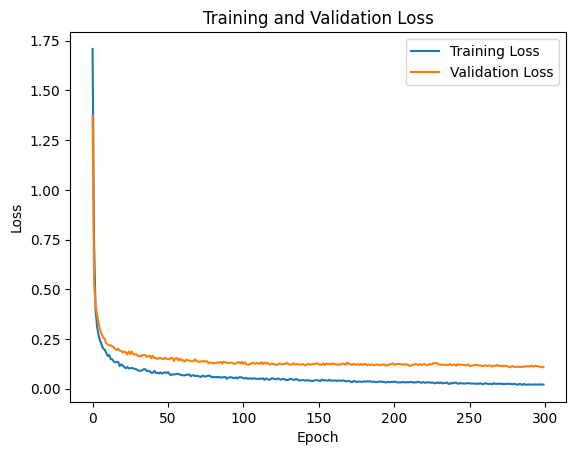

7/7 [==============================] - 0s 6ms/step - loss: 0.1096
Test Loss: 0.10959448665380478
7/7 [==============================] - 2s 4ms/step


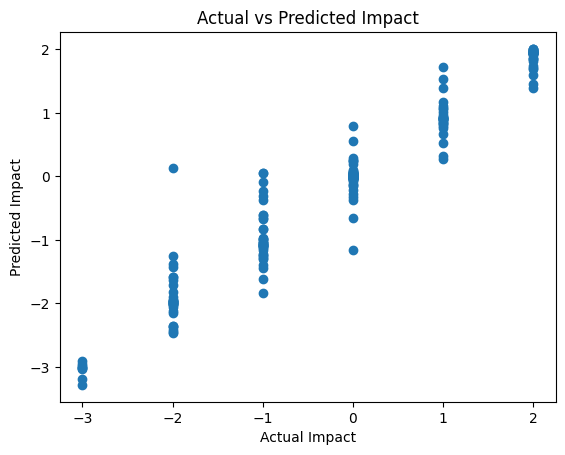

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout

# Load the dataset
data = pd.read_csv("/content/sample_data/output.csv")

# Preprocess the dataset
# Drop unnecessary columns like Name
data = data.drop(columns=["Name"])

# Convert categorical variables to numerical using one-hot encoding
data_encoded = pd.get_dummies(data, columns=["Initial Continent", "Initial Climate", "Final Continent", "Final Climate"])

# Split the dataset into features and target variables
X = data_encoded.drop(columns=["Impact"])
y = data_encoded[["Impact"]]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for Bi-LSTM
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(1, X_train_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer with 1 neuron for Impact

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=300, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

# Make predictions
predictions = model.predict(X_test_reshaped)

# Plot actual vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Impact')
plt.ylabel('Predicted Impact')
plt.title('Actual vs Predicted Impact')
plt.show()


Epoch 1/500
25/25 [==============================] - 3s 35ms/step - loss: 1.8949 - val_loss: 1.6220
Epoch 2/500
25/25 [==============================] - 0s 16ms/step - loss: 1.4106 - val_loss: 1.4765
Epoch 3/500
25/25 [==============================] - 0s 19ms/step - loss: 1.3211 - val_loss: 1.4297
Epoch 4/500
25/25 [==============================] - 1s 28ms/step - loss: 1.2712 - val_loss: 1.3884
Epoch 5/500
25/25 [==============================] - 1s 24ms/step - loss: 1.2417 - val_loss: 1.3345
Epoch 6/500
25/25 [==============================] - 1s 23ms/step - loss: 1.2037 - val_loss: 1.2673
Epoch 7/500
25/25 [==============================] - 1s 22ms/step - loss: 1.1540 - val_loss: 1.2123
Epoch 8/500
25/25 [==============================] - 1s 27ms/step - loss: 1.0513 - val_loss: 0.9879
Epoch 9/500
25/25 [==============================] - 1s 24ms/step - loss: 0.8248 - val_loss: 0.7660
Epoch 10/500
25/25 [==============================] - 1s 22ms/step - loss: 0.7128 - val_loss: 0.5359

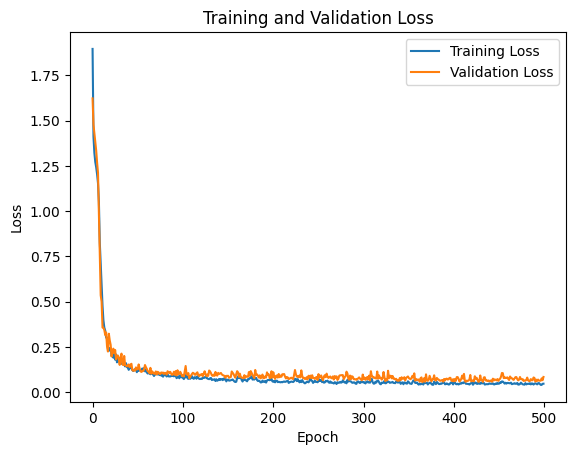

7/7 [==============================] - 0s 7ms/step - loss: 0.0852
Test Loss: 0.08516743034124374
7/7 [==============================] - 0s 5ms/step


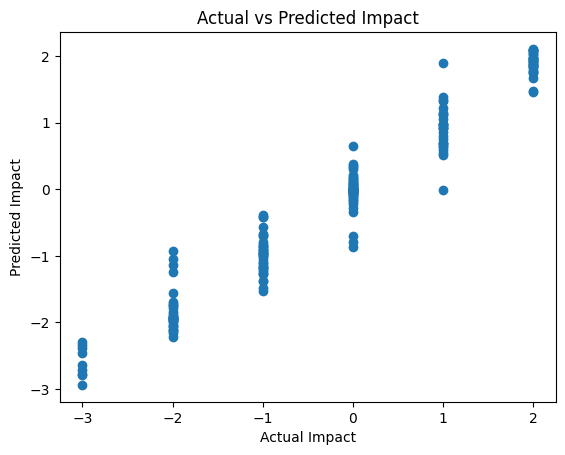

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Load the dataset
data = pd.read_csv("/content/sample_data/output.csv")

# Preprocess the dataset
# Drop unnecessary columns like Name
data = data.drop(columns=["Name"])

# Convert categorical variables to numerical using one-hot encoding
data_encoded = pd.get_dummies(data, columns=["Initial Continent", "Initial Climate", "Final Continent", "Final Climate"])

# Split the dataset into features and target variables
X = data_encoded.drop(columns=["Impact"])
y = data_encoded[["Impact"]]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for RNN
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer with 1 neuron for Impact

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)

# Make predictions
predictions = model.predict(X_test_reshaped)

# Plot actual vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Impact')
plt.ylabel('Predicted Impact')
plt.title('Actual vs Predicted Impact')
plt.show()
